Итоговая работа
=====================

Представлены данные такси, по которым мы должны предсказать возьмёт ли таксист заказ или нет(driver_response).

Принципы вы знаете, чек-лист аналогичен лабораторной работе.

Чек-лист:
1. Загрузите датасет taxi.csv.
2. Посмотрите на данные. Отобразите общую информацию по признакам (вспомните о describe и info). Напишите в markdown свои наблюдения.
3. Выявите пропуски, а также возможные причины их возникновения. Решите, что следует сделать с ними. Напишите в markdown свои наблюдения.
4. Оцените зависимости переменных между собой. Используйте корреляции. Будет хорошо, если воспользуетесь profile_report. Напишите в markdown свои наблюдения.
5. Определите стратегию преобразования категориальных признаков (т.е. как их сделать адекватными для моделей).
6. Найдите признаки, которые можно разделить на другие, или преобразовать в другой тип данных. Удалите лишние, при необходимости.
7. Разделите выборку на обучаемую и тестовую.
8. Обучите модель. Напишите в markdown свои наблюдения по полученным результатам. Хорошие результаты дают классификаторы RandomForest и XGBoost

Если возникнут затруднения, то смотрите на материал практических занятий. Данного там должно хватить для выполнения всех пунктов. Желаю успеха!

In [36]:
import pandas as pd
from pandas_profiling import ProfileReport

import numpy as np

from geopy.distance import vincenty

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
source = pd.read_csv('taxi.csv')

In [3]:
source

,offer_gk,weekday_key,hour_key,driver_gk,order_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,offer_class_group,ride_type_desc,driver_response
0,1105373,5,20,6080,174182,55.818842,37.334562,55.814567,37.355010,-1.000,-1.000,Economy,private,0
1,759733,5,14,6080,358774,55.805342,37.515023,55.819329,37.466398,18.802,25.217,Standard,private,1
2,416977,6,14,6080,866260,55.813978,37.347688,55.814827,37.354074,6.747,9.800,Economy,private,0
3,889660,2,6,6080,163522,55.745922,37.421748,55.743469,37.431130,-1.000,-1.000,Economy,private,1
4,1120055,4,16,6080,506710,55.803578,37.521602,55.812559,37.527407,12.383,19.250,Economy,private,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,726210,0,2,2442,27360,55.961246,37.413497,55.966694,37.415754,17.378,29.817,Economy,private,0
99996,881472,0,1,2442,381960,55.961246,37.413497,55.964892,37.413543,7.751,12.683,Economy,private,0
99997,626673,1,20,2442,627126,55.961315,37.413497,55.962203,37.416373,46.983,46.217,Standard,private,0
99998,672584,6,21,2442,140623,55.961354,37.413864,55.964892,37.413543,50.029,51.100,Economy,private,0


In [4]:
source.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 14 columns):
offer_gk                  100000 non-null int64
weekday_key               100000 non-null int64
hour_key                  100000 non-null int64
driver_gk                 100000 non-null int64
order_gk                  100000 non-null int64
driver_latitude           100000 non-null float64
driver_longitude          100000 non-null float64
origin_order_latitude     100000 non-null float64
origin_order_longitude    100000 non-null float64
distance_km               100000 non-null float64
duration_min              100000 non-null float64
offer_class_group         100000 non-null object
ride_type_desc            100000 non-null object
driver_response           100000 non-null int64
dtypes: float64(6), int64(6), object(2)
memory usage: 10.7+ MB


In [5]:
source['ride_type_desc'].value_counts()

private      91207
business      8533
affiliate      224
SMB             36
Name: ride_type_desc, dtype: int64

In [6]:
source['offer_class_group'].value_counts()

Economy     48335
Standard    47288
Premium      1773
Delivery     1290
Kids          588
XL            464
VIP           225
VIP+           29
Test            8
Name: offer_class_group, dtype: int64

In [7]:
source['driver_gk'].value_counts()

1421    3014
1060    2780
1126    2328
4490    1784
2442    1588
        ... 
2844      52
1978      52
689       52
854       51
3242      50
Name: driver_gk, Length: 439, dtype: int64

In [8]:
source['order_gk'].value_counts()

853342    14
714527    13
761031    13
828548    12
180487    12
          ..
529767     1
361705     1
57063      1
782999     1
786432     1
Name: order_gk, Length: 81435, dtype: int64

In [9]:
source[source['driver_latitude'] <= 55]['driver_latitude'].value_counts()

-1.0    140
 0.0      1
Name: driver_latitude, dtype: int64

# Описание Датасета

###### Уникальный идентификатор предложения. 
Не имеет смысла в нашем анализе
###### День недели 
от 0 до 6
###### Час
###### ID водителя
Количество водителей - 439, что существенно меньше количества строк в датасете, плюс некоторые имеют статистику от 1000 предложений. Так что будем использовать в модели
###### ID заказа
Некоторые заказы предлагаются нескольким водителям, теоритически, мы могли бы строить предположение о том, откажется ли следующий водитель в зависимости от того, отказались ли предыдущие. Но таких заказов, к сожалению, не очень много. А так я бы конвертировал этот признак в "сколько водителей уже отказались", если бы еще была уверенность в порядке предложения (то есть, что предложили сначала водителю который выше в таблице)  
###### Координаты водителя
По координатам водителя и заказа становится очевидно, что данные относятся к Москве и Москвоской области.  
Есть плохие данные (и в latitude, и в driver_longitude): 140 значений -1.0 и один ноль (видимо нам была неизвестна позиция водителя).
Количество строчек небольшое, так что можно эти данные просто удалить.
###### Координаты клиента
Также есть плохие данные по клиенту: 13 строк строк с -1.0 в координатах
###### Дистанция поездки
-1, когда не указан пункт назначения
###### Расчетное время в пути
-1, когда не указан пункт назначения
###### Класс обслуживания
###### Тип поездки 
частная, бизнес, партнерская, фиг его знает какая SMB

# Удаление плохих данных

In [10]:
fix_gps = source[(source['origin_order_latitude'] > 55 ) & (source['origin_order_longitude'] > 36) 
                 & (source['driver_longitude'] > 36) & (source['driver_latitude'] > 55) ].copy()

У нас есть несколько строк, где дистанция и время до клиента отрицательные или нулевые, такого быть не может. Посмотрим сколько это строк.

In [11]:
fix_gps[(fix_gps['duration_min'] <= 0) & (fix_gps['distance_km'] <= 0)]

# строк довольно много (26235) надо заполнять, но это дальше.

,offer_gk,weekday_key,hour_key,driver_gk,order_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,offer_class_group,ride_type_desc,driver_response
0,1105373,5,20,6080,174182,55.818842,37.334562,55.814567,37.355010,-1.0,-1.0,Economy,private,0
3,889660,2,6,6080,163522,55.745922,37.421748,55.743469,37.431130,-1.0,-1.0,Economy,private,1
6,103326,2,11,6080,615584,55.753508,37.663742,55.757251,37.659064,-1.0,-1.0,Standard,business,1
19,533917,5,8,6080,596531,55.913718,37.401395,55.921554,37.403505,-1.0,-1.0,Standard,business,0
21,123897,4,12,6080,185909,55.766763,37.607275,55.772388,37.606330,-1.0,-1.0,Standard,business,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99981,397745,1,23,2442,383092,55.961397,37.413560,55.962322,37.407117,-1.0,-1.0,Standard,private,0
99987,871592,4,23,2442,802677,55.961121,37.414019,55.961995,37.406355,-1.0,-1.0,Standard,private,0
99991,619039,6,23,2442,323136,55.961239,37.413497,55.962322,37.407117,-1.0,-1.0,Standard,private,0
99992,1021230,1,1,2442,351741,55.961301,37.413497,55.966694,37.415754,0.0,0.0,Standard,private,0


# Анализ данных

Еще до того, как я вышел на след хакатона (стоило ли о нем заикаться на лабораторной работе? :) https://github.com/Ciroel/McKinsey-Big-Data-Hackatone-Task1/blob/master/Exploration.py у меня была идея использовать координаты, но конвертировать их в районы. Выбрасывать координаты совсем (а первая мысль была именно такая, потому что расстояние или время до клиента гораздо лучше выполняют роль) не хочется.

Но блин у того самого парня гораздо проще был подход - выбрать конкретные точки в Москве (с чем, кстати, я бы справился лучше - херовый из него москвич). Однако, я уже взялся за свой подход и вот, что я обнаружил.

Чтобы определить какой район, нам нужны shape данные, которые представляется возможным получить только с openstreetmap.org. И то, просто взять и скачать оттуда данные по району нельзя (вылетает ошибка с нехваткой оперативки на сервере). Пришлось лезть на немецкий сайт с бэкапами OSM https://download.geofabrik.de/russia.html Но выкаченные оттуда данные почему-то не содержали так нужных мне районов.

Я нашел другой способ. Это запросить данные через Overpass api (гайд https://towardsdatascience.com/loading-data-from-openstreetmap-with-python-and-the-overpass-api-513882a27fd0 и краткое описание того, что надо сделать https://qna.habr.com/answer?answer_id=698788#answers_list_answer) и тут до меня начало доходить, как организованы данные в OSM - каждый узел (если это не точка) имеет узлы, которые его ограничивают (район ограничивают линии, линии состоят из точек).

Короче я маленько ошалел с трудоемкости задачи (надо не только все данные получить, но еще и понять находится ли точка в заданных координатах), подумал что до сдачи остается 4 дня, 2 из которых меня не будет у компьютера и решил свою гениальную идею отложить до лучших времен. Когда нибудь я с этой задачей разберусь, обещаю :)

А пока применем подход чувака, но чтобы не быть совсем crtl+c/v добавим несколько своих объектов и исправим явные косяки немца:

In [12]:
points_list = [
    {'name': 'Red Square', 'p': (55.753315, 37.622500)}, # red square
    {'name': 'Ekaretina park', 'p': (55.783199, 37.620724)}, # Екатерининский парк - не самое конечно интересное место, но оставим
    {'name': '3 railway station', 'p': (55.774879, 37.653683)}, # 3 vokzals
    {'name': 'Kievskiy', 'p': (55.743090, 37.564536)}, # Киевский вокзал
    {'name': 'Zoo', 'p': (55.761011, 37.578709)}, # Московский зоопарк
    {'name': 'Domodedovo', 'p': (55.415471, 37.893784)}, # domodedovo
    {'name': 'Vnukovo', 'p': (55.605822, 37.289434)}, # vnukovo
    {'name': 'Sheremetievo', 'p': (55.962587, 37.417308)}, # sheremetievo
    {'name': 'Jukovskiy', 'p': (55.559388, 38.114864)}, # jukovky
    {'name': 'Gorkiy park', 'p': (55.731829, 37.603827)}, # Парк Горького
    {'name': 'Kurskiy', 'p': (55.757268, 37.660072)}, # Курский вокзал
    {'name': 'Paveleckiy', 'p': (55.730138, 37.639674)}, # Павелецкий вокзал
    {'name': 'Savelovskiy', 'p': (55.793941, 37.588292)}, # Савеловский вокзал
    {'name': 'Rijskiy', 'p': (55.792683, 37.633235)}, # Рижский вокзал
    {'name': 'River station', 'p': (55.689473, 37.675826)}, # Южный речной вокзал
    {'name': 'Kolomenskoe', 'p': (55.652949, 37.655614)}, # Коломенское
    {'name': 'Kuzminki', 'p': (55.692518, 37.790123)}, # Парк Кузьминки
    {'name': 'Luzhniki', 'p': (55.718475, 37.558767)}, # Лужники
    {'name': 'MGU', 'p': (55.703940, 37.532994)}, # МГУ
    {'name': 'Poklonka', 'p': (55.735554, 37.516180)}, # Поклонка
    {'name': 'Gorbushka', 'p': (55.741287, 37.501643)}, # Горбушка
    {'name': 'White house', 'p': (55.753955, 37.572146)}, # Белый дом
    {'name': 'Bolshoy', 'p': (55.759605, 37.619533)}, # Большой театр
    {'name': 'Botrinskaya hospital', 'p': (55.781870, 37.554591)}, # Боткинская больница
    {'name': 'Sokolniki', 'p': (55.792050, 37.677762)}, # Сокольники
    {'name': 'VDNH', 'p': (55.824727, 37.640400)}, # ВДНХ
    {'name': 'Botanicheskiy garden', 'p': (55.833858, 37.594953)}, # Ботанически сад
    {'name': 'Silver bor', 'p': (55.779639, 37.446680)}, # Серебрянный бор
    {'name': 'Arhangelskoe', 'p': (55.788846, 37.281396)}, # Архангельское
    {'name': 'Arena Himki', 'p': (55.884864, 37.453019)}, # Арена Химки
    {'name': 'Admiral', 'p': (55.969451, 37.537772)}, # Яхт клуб Адмирал
]

**Я сдаюсь, объектов очень много, с учетом того что еще и область и хочется охватить разные типы объектов.**

Далее надо в любом случае померить расстояние до них от клиента и от водителя (например, если водитель стоит у Шереметьево, то он вряд ли захочет поехать к клиенту из Химок)

Но в тоже время я хочу немного изменить подход. Во-первых, опять таки надо привнести что-то свое в чужой код. Во-вторых, я думаю, что это не очень оптимально в алгоритм отправлять все расстояния до объектов, по мне важен именно объект с которого делают заказ или к которому близок водитель. Конечно, мой метод не очень хорошо будет работать из-за малого количества точек в поинт-листе, тем более что во многих случаях в этот лист надо не точки забивать, а границы объектов (Парк горького большой, выходов из него много). Дальше комментарии будут на английском (буду использовать свой гитхаб для поиска работы)

In [13]:
def closest_point(point, driver = True):
    global points_list
    
    # we will ignore objects if distance more than 5 km
    limit_distance = 5
    closest_distance = limit_distance
    closest_point = 'None'
    
    # one function for driver and client
    if driver:
        latitude = 'driver_latitude'
        longitude = 'driver_longitude'
    else:
        latitude = 'origin_order_latitude'
        longitude = 'origin_order_longitude'
    
    for p in points_list:
        distance = vincenty((point[latitude], point[longitude]), p['p']).km
        
        if distance < closest_distance and distance < limit_distance:
            closest_distance = distance
            closest_point = p['name']
    
    return closest_point


def client_point(point):
    return closest_point(point, False)


fix_gps['close_to_driver'] = fix_gps[['driver_latitude', 'driver_longitude']].apply(closest_point, axis = 1)
fix_gps['close_to_client'] = fix_gps[['origin_order_latitude', 'origin_order_longitude']].apply(client_point, axis = 1)

D:\Python\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.


When i first looked at dataset i thought that distance column was a distance to client, but in fact it is a disctance to a destination point. This is why we can additionally add a feature called "distance to client" - calculate a distance on a straight line based on coordinates.

In [14]:
def calc_distance(p):
    return vincenty((p['driver_latitude'], p['driver_longitude']), 
                            (p['origin_order_latitude'], p['origin_order_longitude'])).km

fix_gps['distance_to_client'] = fix_gps[['driver_latitude', 'driver_longitude',
                                         'origin_order_latitude', 'origin_order_longitude']].apply(calc_distance, axis = 1) 

D:\Python\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  This is separate from the ipykernel package so we can avoid doing imports until


In [15]:
fix_gps

,offer_gk,weekday_key,hour_key,driver_gk,order_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,offer_class_group,ride_type_desc,driver_response,close_to_driver,close_to_client,distance_to_client
0,1105373,5,20,6080,174182,55.818842,37.334562,55.814567,37.355010,-1.000,-1.000,Economy,private,0,Arhangelskoe,None,1.367355
1,759733,5,14,6080,358774,55.805342,37.515023,55.819329,37.466398,18.802,25.217,Standard,private,1,Botrinskaya hospital,Silver bor,3.423260
2,416977,6,14,6080,866260,55.813978,37.347688,55.814827,37.354074,6.747,9.800,Economy,private,0,None,None,0.411356
3,889660,2,6,6080,163522,55.745922,37.421748,55.743469,37.431130,-1.000,-1.000,Economy,private,1,Silver bor,Silver bor,0.649440
4,1120055,4,16,6080,506710,55.803578,37.521602,55.812559,37.527407,12.383,19.250,Economy,private,1,Botrinskaya hospital,Botrinskaya hospital,1.064116
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,726210,0,2,2442,27360,55.961246,37.413497,55.966694,37.415754,17.378,29.817,Economy,private,0,Sheremetievo,Sheremetievo,0.622748
99996,881472,0,1,2442,381960,55.961246,37.413497,55.964892,37.413543,7.751,12.683,Economy,private,0,Sheremetievo,Sheremetievo,0.405960
99997,626673,1,20,2442,627126,55.961315,37.413497,55.962203,37.416373,46.983,46.217,Standard,private,0,Sheremetievo,Sheremetievo,0.205033
99998,672584,6,21,2442,140623,55.961354,37.413864,55.964892,37.413543,50.029,51.100,Economy,private,0,Sheremetievo,Sheremetievo,0.394435


# Searching for bad values

Maybe we have some not relevant data.

For example, distance more than 500 km, we have about 30 rows of data like this and strangely enough most of them have positive driver responses. But still, I don't think it is necessary to remove them from the analytics, because they will help us to predict response for similar drive distance.

What I really want to remove from the data set is records with offer_class_group = test (8 values), because the name tell us it is not real data probably.

In [16]:
fix_gps[fix_gps['offer_class_group'] == 'Test']

,offer_gk,weekday_key,hour_key,driver_gk,order_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,offer_class_group,ride_type_desc,driver_response,close_to_driver,close_to_client,distance_to_client
12092,849177,5,20,3763,83260,55.820917,37.650258,55.827038,37.660981,-1.0,-1.0,Test,SMB,0,VDNH,VDNH,0.957148
31035,1122239,3,23,6290,493264,55.959273,37.415073,55.962322,37.407117,-1.0,-1.0,Test,SMB,0,Sheremetievo,Sheremetievo,0.601793
43940,897797,5,20,591,83260,55.821477,37.611275,55.827038,37.660981,-1.0,-1.0,Test,SMB,1,Botanicheskiy garden,VDNH,3.176284
54657,954625,1,18,172,203179,55.823113,37.508883,55.829178,37.513307,-1.0,-1.0,Test,SMB,1,None,None,0.729975
65028,1039723,1,15,1916,357476,55.881810,37.654255,55.872580,37.668403,-1.0,-1.0,Test,SMB,1,None,None,1.356561
82848,990065,2,14,3371,325838,55.775556,37.582864,55.773730,37.591352,-1.0,-1.0,Test,SMB,1,Zoo,Zoo,0.570146
95758,159224,5,17,1126,392645,55.761183,37.657616,55.757251,37.659064,-1.0,-1.0,Test,SMB,1,Kurskiy,Kurskiy,0.447118
97311,1060685,3,23,6302,493264,55.964894,37.413532,55.962322,37.407117,-1.0,-1.0,Test,SMB,1,Sheremetievo,Sheremetievo,0.492451


In [17]:
fix_gps = fix_gps[fix_gps['offer_class_group'] != 'Test']

When a destination is not set, columns "distance_km" and "duration_min" have value "-1". But we have few rows with zero values. Lets just delete them.  

In [18]:
fix_gps[fix_gps['distance_km'] == 0]

,offer_gk,weekday_key,hour_key,driver_gk,order_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,offer_class_group,ride_type_desc,driver_response,close_to_driver,close_to_client,distance_to_client
859,346101,4,12,4215,70206,55.758458,37.710545,55.747802,37.715600,0.0,0.0,Economy,private,1,Kurskiy,Kurskiy,1.228135
1179,166480,5,8,1706,234100,55.787066,37.563235,55.792505,37.563787,0.0,0.0,Economy,private,1,Botrinskaya hospital,Botrinskaya hospital,0.606557
2435,839922,3,12,6792,845047,55.415367,37.898310,55.410307,37.902451,0.0,0.0,Standard,private,1,Domodedovo,Domodedovo,0.621396
2918,904433,5,18,1514,228992,55.681763,37.480773,55.671333,37.464131,0.0,0.0,Standard,private,0,MGU,None,1.563542
3357,149416,4,6,4269,401598,55.961844,37.409798,55.961995,37.406355,0.0,0.0,Economy,private,0,Sheremetievo,Sheremetievo,0.215686
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97780,891112,0,23,6302,240143,55.964894,37.413532,55.962322,37.407117,0.0,0.0,Standard,private,0,Sheremetievo,Sheremetievo,0.492451
98847,1076090,1,0,2442,607562,55.961366,37.413864,55.962322,37.407117,0.0,0.0,Standard,private,0,Sheremetievo,Sheremetievo,0.434615
99280,325512,4,23,2442,690788,55.961371,37.413497,55.962322,37.407117,0.0,0.0,Standard,private,0,Sheremetievo,Sheremetievo,0.412287
99937,213143,1,0,2442,378241,55.961366,37.413864,55.962322,37.407117,0.0,0.0,Economy,private,0,Sheremetievo,Sheremetievo,0.434615


In [19]:
fix_gps = fix_gps[fix_gps['distance_km'] != 0]

# Correlation

Before we build ProfileReport (by the way I did it already several times on the previous stages) let's exclude distance and duration with "-1" values. They will harm the correlation report, the data set has about 25% such rows, so correlation between distance_km and duration_min will be very strong (i think it will be still strong which is fair).

In [20]:
ProfileReport(fix_gps[fix_gps['distance_km'] != -1]) 

Obviously enough origin_order and driver coordinates are highly correlated, duration_min has a high correlation to distance_km. We can remove one of them without a serious model accuracy rate.  
Target parameter - drive_response - has a medium correlation with distance_km and distance to the client. Correlation to coordinates is stronger than the correlation of the casted feature "distance to client" (to bad :). Time and day are not so important.

# Machine learning

As a model pattern i choose RandomForest
Let's prepare data first:

In [39]:
fix_gps.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99686 entries, 0 to 99999
Data columns (total 17 columns):
offer_gk                  99686 non-null int64
weekday_key               99686 non-null int64
hour_key                  99686 non-null int64
driver_gk                 99686 non-null int64
order_gk                  99686 non-null int64
driver_latitude           99686 non-null float64
driver_longitude          99686 non-null float64
origin_order_latitude     99686 non-null float64
origin_order_longitude    99686 non-null float64
distance_km               99686 non-null float64
duration_min              99686 non-null float64
offer_class_group         99686 non-null object
ride_type_desc            99686 non-null object
driver_response           99686 non-null int64
close_to_driver           99686 non-null object
close_to_client           99686 non-null object
distance_to_client        99686 non-null float64
dtypes: float64(7), int64(6), object(4)
memory usage: 13.7+ MB


In [43]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

X = fix_gps[['driver_gk', 'weekday_key', 'hour_key', 'driver_latitude', 'driver_longitude', 'origin_order_latitude', 
             'origin_order_longitude', 'distance_to_client', 'close_to_driver', 'close_to_client', 
             'distance_km', 'duration_min', 
             'offer_class_group', 'ride_type_desc']]
y = fix_gps['driver_response']

# Label encoding
labelEnc = LabelEncoder()
columns_for_encode = ["offer_class_group", "ride_type_desc", 'close_to_driver', 'close_to_client']
for column in columns_for_encode:
    X[column] = labelEnc.fit_transform(X[column])

# Devide data - train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

In [51]:
from sklearn.ensemble import RandomForestClassifier

# Model learn, 100 trees
model=RandomForestClassifier(n_estimators=100)
model.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

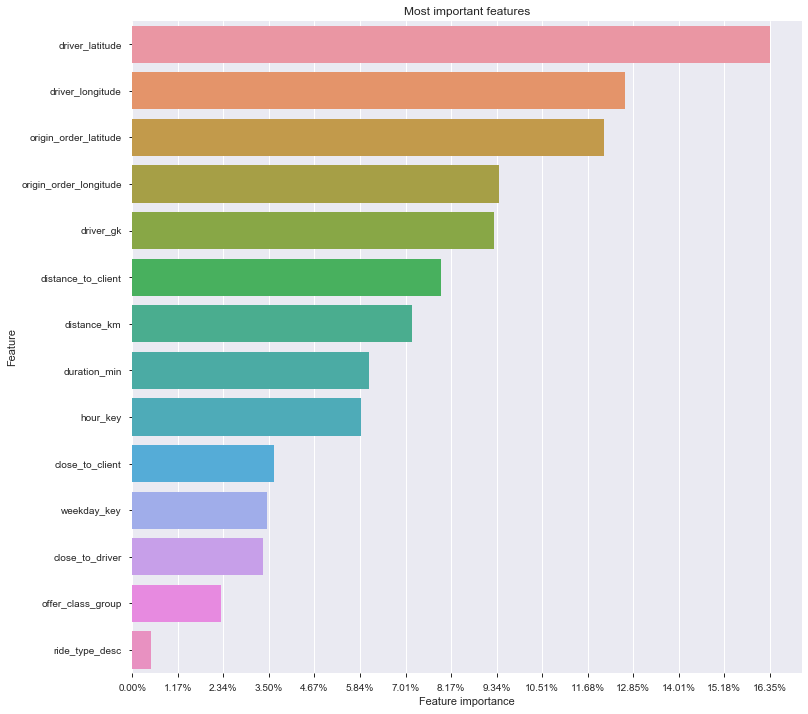

,0
driver_latitude,0.163488
driver_longitude,0.126408
origin_order_latitude,0.120936
origin_order_longitude,0.094118
driver_gk,0.092806
distance_to_client,0.079173
distance_km,0.071625
duration_min,0.060769
hour_key,0.058675
close_to_client,0.036333


In [52]:
headers = list(X_train.columns.values)

# Feature importance
feature_imp = pd.Series(model.feature_importances_,index=headers).sort_values(ascending=False)

f, ax = plt.subplots(figsize=(12, 12))
sns.barplot(x=feature_imp, y=feature_imp.index)

x_ticks = np.linspace(start = 0, stop=max(feature_imp), num =  15, endpoint = True)
plt.xticks(x_ticks, [f"{x:0.2%}" for x in x_ticks])

# Desciption of the chart
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.title("Most important features")

plt.show()
pd.DataFrame(feature_imp)

New categorical features "close to client/driver" is better that last 2 (almost not important). The correlation showed it to us earlier - most important is a client and a driver place location.

In [63]:
# Real vs predict
score = pd.DataFrame({"driver_response":y_test, "Prediction": model.predict(X_test).tolist()})
score.sample(15).sort_values('driver_response')

,driver_response,Prediction
55423,0,0
34161,0,0
42086,0,0
69887,0,0
85526,0,1
65441,1,1
14846,1,1
33516,1,1
20538,1,1
47653,1,1


In [65]:
# Metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

print('Metrics')
print('F1: ', f1_score(score['driver_response'], score['Prediction'], average="macro"))
print('Accuracy score', accuracy_score(score['driver_response'], score['Prediction']))
print('Precision score', precision_score(score['driver_response'], score['Prediction'], average="macro"))
print('Recall score', recall_score(score['driver_response'], score['Prediction'], average="macro"))

Metrics
F1:  0.8149859325354742
Accuracy score 0.8152272043334337
Precision score 0.818022983448152
Recall score 0.8157969532223108


Well, it is 80% of accuracy. Not bad. Can apply some changes, to find if it is best setup.

,driver_gk,weekday_key,hour_key,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_to_client,close_to_driver,close_to_client,distance_km,duration_min,offer_class_group,ride_type_desc,driver_response,Prediction
52133,5280,0,1,55.752881,37.611471,55.762689,37.634389,1.806306,21,4,-1.000,-1.000,1,2,0,0
97778,6302,5,20,55.964894,37.413532,55.966694,37.415754,0.243762,25,25,31.534,33.167,1,3,0,0
76143,2006,5,14,55.745371,37.565610,55.755267,37.568117,1.112984,12,30,1.843,6.550,4,3,0,0
2667,6792,0,3,55.415502,37.898557,55.410307,37.902451,0.628754,7,7,-1.000,-1.000,4,3,0,0
45468,2782,6,2,55.606963,37.604650,55.617408,37.592552,1.390512,18,18,-1.000,-1.000,4,3,1,1
91225,22,5,7,55.871928,37.494128,55.895524,37.480051,2.770936,2,2,32.374,41.867,4,3,1,1
96868,1126,3,1,55.952007,37.415643,55.964892,37.413543,1.440613,25,25,20.302,25.367,1,3,0,0
18902,5874,6,0,55.767058,37.638040,55.768459,37.625907,0.777355,0,4,15.074,29.467,1,3,0,0
9917,6580,3,9,55.849578,37.415710,55.840190,37.377631,2.604323,2,18,-1.000,-1.000,4,2,0,0
47531,4246,3,21,55.768709,37.589646,55.774111,37.587972,0.610553,31,31,19.540,29.400,1,3,1,1


In [74]:
# remove driver and origin_order longitude
X = fix_gps[['driver_gk', 'weekday_key', 'hour_key', 'driver_latitude', 'origin_order_latitude', 
              'distance_to_client', 'close_to_driver', 'close_to_client', 
             'distance_km', 'duration_min', 
             'offer_class_group', 'ride_type_desc']]
y = fix_gps['driver_response']

# Label encoding
labelEnc = LabelEncoder()
columns_for_encode = ["offer_class_group", "ride_type_desc", 'close_to_driver', 'close_to_client']
for column in columns_for_encode:
    X[column] = labelEnc.fit_transform(X[column])

# Devide data - train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

# Model learn, 100 trees
model=RandomForestClassifier(n_estimators=100)
model.fit(X_train,y_train)

# Real vs predict
score = pd.DataFrame({"driver_response":y_test, "Prediction": model.predict(X_test).tolist()})

print('Metrics')
print('F1: ', f1_score(score['driver_response'], score['Prediction'], average="macro"))
print('Accuracy score', accuracy_score(score['driver_response'], score['Prediction']))
print('Precision score', precision_score(score['driver_response'], score['Prediction'], average="macro"))
print('Recall score', recall_score(score['driver_response'], score['Prediction'], average="macro"))

Metrics
F1:  0.8116585449796552
Accuracy score 0.8119670980038118
Precision score 0.8152865094758508
Recall score 0.8125901970005143


**slight drop**

In [76]:
# remove driver and origin_order longitude
# additionally remove last 2 categorical
X = fix_gps[['driver_gk', 'weekday_key', 'hour_key', 'driver_latitude', 'origin_order_latitude', 
              'distance_to_client', 'close_to_driver', 'close_to_client', 
             'distance_km', 'duration_min']]
y = fix_gps['driver_response']

# Label encoding
labelEnc = LabelEncoder()
columns_for_encode = [ 'close_to_driver', 'close_to_client']
for column in columns_for_encode:
    X[column] = labelEnc.fit_transform(X[column])

# Devide data - train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

# Model learn, 100 trees
model=RandomForestClassifier(n_estimators=100)
model.fit(X_train,y_train)

# Real vs predict
score = pd.DataFrame({"driver_response":y_test, "Prediction": model.predict(X_test).tolist()})

print('Metrics')
print('F1: ', f1_score(score['driver_response'], score['Prediction'], average="macro"))
print('Accuracy score', accuracy_score(score['driver_response'], score['Prediction']))
print('Precision score', precision_score(score['driver_response'], score['Prediction'], average="macro"))
print('Recall score', recall_score(score['driver_response'], score['Prediction'], average="macro"))

Metrics
F1:  0.8011869789537007
Accuracy score 0.8015849132310161
Precision score 0.8053787111466049
Recall score 0.8022590401094816


**1% drop**

In [80]:
# remove all my features
X = fix_gps[['driver_gk', 'weekday_key', 'hour_key', 'driver_latitude', 'origin_order_latitude', 
             'distance_km', 'duration_min', 
             'offer_class_group', 'ride_type_desc']]

# Label encoding
labelEnc = LabelEncoder()
columns_for_encode = ["offer_class_group", "ride_type_desc"]
for column in columns_for_encode:
    X[column] = labelEnc.fit_transform(X[column])

# Devide data - train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

# Model learn, 100 trees
model=RandomForestClassifier(n_estimators=100)
model.fit(X_train,y_train)

# Real vs predict
score = pd.DataFrame({"driver_response":y_test, "Prediction": model.predict(X_test).tolist()})

print('Metrics')
print('F1: ', f1_score(score['driver_response'], score['Prediction'], average="macro"))
print('Accuracy score', accuracy_score(score['driver_response'], score['Prediction']))
print('Precision score', precision_score(score['driver_response'], score['Prediction'], average="macro"))
print('Recall score', recall_score(score['driver_response'], score['Prediction'], average="macro"))

Metrics
F1:  0.8141966264028899
Accuracy score 0.8143745611395325
Precision score 0.8165768692213149
Recall score 0.814880430931228


# Summary

Now we have quite good model for predicting a driver response more than 80 of 100 times.

My brand new features unfotunatelly did not increase an accuracy.